In [1]:
# act with actor critic on moon lander 

In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import pdb

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical

import sys
import time
from IPython.display import display, clear_output

from utils import ReturnTracker, Agent
from tqdm.auto import tqdm, trange

import os

In [2]:
class ActorCritic(nn.Module):
    # attention, this implementation varies slightly from the one in our slides to achieve faster convergence!
    def __init__(self, env, lr=0.02, gamma=0.99, device='cpu'):
        super(ActorCritic, self).__init__()
        self.embed = nn.Linear(8, 128).to(device)
        self.action_log_probs = nn.Linear(128, 4).to(device)
        self.values = nn.Linear(128, 1).to(device)
        
        self.reset_memory()
        
        self.total_num_steps = 0
        self.env = env
        self.lr = lr
        self.gamma = gamma
        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        self.device = device

    def forward(self, state):
        state = torch.from_numpy(state).float().to(self.device)
        state = F.relu(self.embed(state))
        state_value = self.values(state)
        
        action_probs = F.softmax(self.action_log_probs(state), dim=-1)
        action_distribution = Categorical(action_probs)
        action = action_distribution.sample()
        
        self.logprobs_memory.append(action_distribution.log_prob(action))
        self.values_memory.append(state_value)
        
        return action.item()
    
    def predict(self, state):
        self.eval()
        return self.forward(state)
    
    def calc_loss(self):
        
        # calculating discounted rewards:
        returns = []
        dis_reward = 0
        for reward in self.rewards_memory[::-1]:
            dis_reward = reward + self.gamma * dis_reward
            returns.insert(0, dis_reward)
                
        # normalizing the returns:
        returns = torch.tensor(returns).to(self.device)
        returns = (returns - returns.mean()) / (returns.std())
        
        loss = 0
        for logprob, value, return_ in zip(self.logprobs_memory, self.values_memory, returns):
            advantage = return_  - value.item()
            action_loss = -logprob * advantage
            value_loss = F.smooth_l1_loss(value, return_.flatten())
            loss += (action_loss + value_loss)   
        return loss
    
    def learn(self, episodes, max_steps=None, tracker=None, verb=True):
        
        self.train()
        
        iterator = range(episodes)
        if verb:
            iterator = tqdm(iterator, leave=True)
        
        for episode in iterator:

            if tracker is not None:
                tracker.new_episode()
            
            state, info = self.env.reset()
            
            returns = 0
            steps = 0
            terminated = False
            truncated = False
            
            while not terminated and not truncated:
                
                # pdb.set_trace()
                action = self.forward(state)
                
                new_state, reward, terminated, truncated, info = self.env.step(action)
                self.rewards_memory.append(reward)
                    
                state = new_state
                self.total_num_steps += 1
                steps += 1
                returns += reward

                if tracker is not None:
                    tracker.add(reward)
                
                if max_steps is not None:
                    if steps > max_steps:
                        break

            #update
            self.optimizer.zero_grad()
            loss = self.calc_loss()
            loss.backward()
            self.optimizer.step()        
            self.reset_memory()
                
            if verb:
                iterator.set_description(f"total steps: {self.total_num_steps}, episode: {episode}, return: {returns:.4f}")
    
    def reset_memory(self):
        self.logprobs_memory = []
        self.values_memory = []
        self.rewards_memory = []
        

    def save(self, path):
        if not os.path.exists(path):
            os.makedirs(path)
        torch.save(self.state_dict(), os.path.join(path, "actor_critic.pt"))

    @classmethod
    def load(
            cls,
            env,
            path,
            device="cpu",
            **kwargs,
    ):
        agent = cls(env, device=device, **kwargs)
        agent.load_state_dict(
            torch.load(os.path.join(path, "actor_critic.pt"), map_location=device)
        )
        return agent

In [3]:
env = gym.make("LunarLander-v2", continuous=False, render_mode='rgb_array').env


In [4]:
state, info = env.reset()


In [5]:
agent = ActorCritic(env)



In [6]:
tracker = ReturnTracker()


In [7]:
agent.learn(episodes=3000,
            max_steps=1000, 
            tracker=tracker)


  0%|          | 0/3000 [00:00<?, ?it/s]

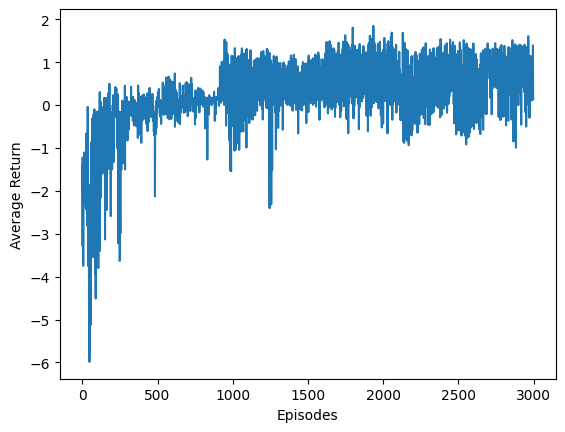

In [8]:
tracker.plot(smooth=1)


In [15]:
# test

while True:
    
    terminated, truncated = False, False
    
    state, info = env.reset()
    
    steps = 0
    returns = 0
    
    while not terminated and not truncated:

        time.sleep(.05)
        clear_output(wait=True)

        action = agent.predict(state)
        new_state, reward, terminated, truncated, info = env.step(action)

        steps += 1
        state = new_state
        returns += reward
        
        print('steps: {}, returns: {}'.format(steps, returns))

        plt.imshow(env.render())
        plt.axis('off')
        plt.show()
    
        sys.stdout.flush()
        
        if steps > 300 or returns > 200:
            break
    
    time.sleep(1.)

steps: 91, returns: 42.01111070218411


KeyboardInterrupt: 

In [12]:
agent.save('models')

In [13]:
agent = ActorCritic.load(env, 'models')